# GAMA-12 Selection Functions
## Depth maps and selection functions

The simplest selection function available is the field MOC which specifies the area for which there is Herschel data. Each pristine catalogue also has a MOC defining the area for which that data is available.

The next stage is to provide mean flux standard deviations which act as a proxy for the catalogue's 5$\sigma$ depth

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))
import datetime
print("This notebook was executed on: \n{}".format(datetime.datetime.now()))

This notebook was run with herschelhelp_internal version: 
017bb1e (Mon Jun 18 14:58:59 2018 +0100)
This notebook was executed on: 
2019-01-29 12:07:42.907451


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

import os
import time

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table, join
import numpy as np
from pymoc import MOC
import healpy as hp
#import pandas as pd #Astropy has group_by function so apandas isn't required.
import seaborn as sns

import warnings
#We ignore warnings - this is a little dangerous but a huge number of warnings are generated by empty cells later
warnings.filterwarnings('ignore')

from herschelhelp_internal.utils import inMoc, coords_to_hpidx, flux_to_mag
from herschelhelp_internal.masterlist import find_last_ml_suffix, nb_ccplots

from astropy.io.votable import parse_single_table

In [3]:
FIELD = 'GAMA-12'
#FILTERS_DIR = "/Users/rs548/GitHub/herschelhelp_python/database_builder/filters/"
FILTERS_DIR = "/opt/herschelhelp_python/database_builder/filters/"

In [4]:
TMP_DIR = os.environ.get('TMP_DIR', "./data_tmp")
OUT_DIR = os.environ.get('OUT_DIR', "./data")
SUFFIX = find_last_ml_suffix()
#SUFFIX = "20171016"

master_catalogue_filename = "master_catalogue_{}_{}.fits".format(FIELD.lower(), SUFFIX)
master_catalogue = Table.read("{}/{}".format(OUT_DIR, master_catalogue_filename))

print("Depth maps produced using: {}".format(master_catalogue_filename))

ORDER = 10
#TODO write code to decide on appropriate order

field_moc = MOC(filename="../../dmu2/dmu2_field_coverages/{}_MOC.fits".format(FIELD))

Depth maps produced using: master_catalogue_gama-12_20190128.fits


In [5]:
# Remove sources whose signal to noise ratio is less than five as these will have been selected using forced 
# photometry and so the errors will not refelct the RMS of the map 
for n,col in enumerate(master_catalogue.colnames):
    if col.startswith("f_"):
        err_col = "ferr{}".format(col[1:])
        errs = master_catalogue[err_col]
        fluxes = master_catalogue[col]
        mask = fluxes/errs < 5.0
        master_catalogue[col][mask] = np.nan
        master_catalogue[err_col][mask] = np.nan

## I - Group masterlist objects by healpix cell and calculate depths
We add a column to the masterlist catalogue for the target order healpix cell <i>per object</i>.

In [6]:
#Add a column to the catalogue with the order=ORDER hp_idx
master_catalogue.add_column(Column(data=coords_to_hpidx(master_catalogue['ra'],
                                                       master_catalogue['dec'],
                                                       ORDER), 
                                   name="hp_idx_O_{}".format(str(ORDER))
                                  )
                           )

In [7]:
# Convert catalogue to pandas and group by the order=ORDER pixel

group = master_catalogue.group_by(["hp_idx_O_{}".format(str(ORDER))])

In [8]:
#Downgrade the groups from order=ORDER to order=13 and then fill out the appropriate cells
#hp.pixelfunc.ud_grade([2599293, 2599294], nside_out=hp.order2nside(13))

## II Create a table of all Order=13 healpix cells in the field and populate it
We create a table with every order=13 healpix cell in the field MOC. We then calculate the healpix cell at lower order that the order=13 cell is in. We then fill in the depth at every order=13 cell as calculated for the lower order cell that that the order=13 cell is inside.

In [9]:
depths = Table()
depths['hp_idx_O_13'] = list(field_moc.flattened(13))

In [10]:
depths[:10].show_in_notebook()

idx,hp_idx_O_13
0,452984832
1,452984833
2,452984834
3,452984835
4,452984836
5,452984837
6,452984838
7,452984839
8,452984840
9,452984841


In [11]:
depths.add_column(Column(data=hp.pixelfunc.ang2pix(2**ORDER,
                     hp.pixelfunc.pix2ang(2**13, depths['hp_idx_O_13'], nest=True)[0],
                     hp.pixelfunc.pix2ang(2**13, depths['hp_idx_O_13'], nest=True)[1],
                     nest = True),
                     name="hp_idx_O_{}".format(str(ORDER))
                        )
                 )

In [12]:
depths[:10].show_in_notebook()

idx,hp_idx_O_13,hp_idx_O_10
0,452984832,7077888
1,452984833,7077888
2,452984834,7077888
3,452984835,7077888
4,452984836,7077888
5,452984837,7077888
6,452984838,7077888
7,452984839,7077888
8,452984840,7077888
9,452984841,7077888


In [13]:
for col in master_catalogue.colnames:
    if col.startswith("f_"):
        errcol = "ferr{}".format(col[1:])
        depths = join(depths, 
                      group["hp_idx_O_{}".format(str(ORDER)), errcol].groups.aggregate(np.nanmean),
                     join_type='left')
        depths[errcol].name = errcol + "_mean"
        depths = join(depths, 
                      group["hp_idx_O_{}".format(str(ORDER)), col].groups.aggregate(lambda x: np.nanpercentile(x, 90.)),
                     join_type='left')
        depths[col].name = col + "_p90"

depths[:10].show_in_notebook()

idx,hp_idx_O_13,hp_idx_O_10,ferr_ap_decam_g_mean,f_ap_decam_g_p90,ferr_decam_g_mean,f_decam_g_p90,ferr_ap_decam_r_mean,f_ap_decam_r_p90,ferr_decam_r_mean,f_decam_r_p90,ferr_ap_decam_z_mean,f_ap_decam_z_p90,ferr_decam_z_mean,f_decam_z_p90,ferr_ap_suprime_g_mean,f_ap_suprime_g_p90,ferr_suprime_g_mean,f_suprime_g_p90,ferr_ap_suprime_r_mean,f_ap_suprime_r_p90,ferr_suprime_r_mean,f_suprime_r_p90,ferr_ap_suprime_i_mean,f_ap_suprime_i_p90,ferr_suprime_i_mean,f_suprime_i_p90,ferr_ap_suprime_z_mean,f_ap_suprime_z_p90,ferr_suprime_z_mean,f_suprime_z_p90,ferr_ap_suprime_y_mean,f_ap_suprime_y_p90,ferr_suprime_y_mean,f_suprime_y_p90,ferr_ap_omegacam_u_mean,f_ap_omegacam_u_p90,ferr_omegacam_u_mean,f_omegacam_u_p90,ferr_ap_omegacam_g_mean,f_ap_omegacam_g_p90,ferr_omegacam_g_mean,f_omegacam_g_p90,ferr_ap_omegacam_r_mean,f_ap_omegacam_r_p90,ferr_omegacam_r_mean,f_omegacam_r_p90,ferr_ap_omegacam_i_mean,f_ap_omegacam_i_p90,ferr_omegacam_i_mean,f_omegacam_i_p90,ferr_ap_gpc1_g_mean,f_ap_gpc1_g_p90,ferr_gpc1_g_mean,f_gpc1_g_p90,ferr_ap_gpc1_r_mean,f_ap_gpc1_r_p90,ferr_gpc1_r_mean,f_gpc1_r_p90,ferr_ap_gpc1_i_mean,f_ap_gpc1_i_p90,ferr_gpc1_i_mean,f_gpc1_i_p90,ferr_ap_gpc1_z_mean,f_ap_gpc1_z_p90,ferr_gpc1_z_mean,f_gpc1_z_p90,ferr_ap_gpc1_y_mean,f_ap_gpc1_y_p90,ferr_gpc1_y_mean,f_gpc1_y_p90,ferr_ap_ukidss_y_mean,f_ap_ukidss_y_p90,ferr_ukidss_y_mean,f_ukidss_y_p90,ferr_ap_ukidss_j_mean,f_ap_ukidss_j_p90,ferr_ukidss_j_mean,f_ukidss_j_p90,ferr_ap_ukidss_h_mean,f_ap_ukidss_h_p90,ferr_ukidss_h_mean,f_ukidss_h_p90,ferr_ap_ukidss_k_mean,f_ap_ukidss_k_p90,ferr_ukidss_k_mean,f_ukidss_k_p90,ferr_ap_vista_z_mean,f_ap_vista_z_p90,ferr_vista_z_mean,f_vista_z_p90,ferr_ap_vista_y_mean,f_ap_vista_y_p90,ferr_vista_y_mean,f_vista_y_p90,ferr_ap_vista_j_mean,f_ap_vista_j_p90,ferr_vista_j_mean,f_vista_j_p90,ferr_ap_vista_h_mean,f_ap_vista_h_p90,ferr_vista_h_mean,f_vista_h_p90,ferr_ap_vista_ks_mean,f_ap_vista_ks_p90,ferr_vista_ks_mean,f_vista_ks_p90
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,uJy,uJy,,,uJy,uJy,,,uJy,uJy,,,uJy,uJy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,418870903,6544857,nan,nan,nan,nan,nan,nan,nan,nan,0.7244428,30.47033271789551,0.4332496,28.859434127807617,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.7203741106424314,4.226689706733889,nan,nan,1.1277800512051432,11.068269939586912,1.0566371170798494,8.590130989694243,0.7268498549820356,18.548420327446713,0.9587195792798897,17.716335385735455,2.0276057668759533,27.395108281794997,1.7860161967029509,27.712195945478307,3.72421861066248,34.196446882499274,2.617814829925206,34.50906586788093,3.7342746,28.607540130615234,nan,nan,4.5572295,53.862796783447266,6.021867,46.81786346435547,4.149413,54.5397689819336,7.6806154,52.189874267578126,5.8566217,61.47573318481445,9.801786,71.39154052734376,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,418870910,6544857,nan,nan,nan,nan,nan,nan,nan,nan,0.7244428,30.47033271789551,0.4332496,28.859434127807617,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.7203741106424314,4.226689706733889,nan,nan,1.1277800512051432,11.068269939586912,1.0566371170798494,8.590130989694243,0.7268498549820356,18.548420327446713,0.9587195792798897,17.716335385735455,2.0276057668759533,27.395108281794997,1.7860161967029509,27.712195945478307,3.72421861066248,34.196446882499274,2.617814829925206,34.50906586788093,3.7342746,28.607540130615234,nan,nan,4.5572295,53.862796783447266,6.021867,46.81786346435547,4.149413,54.5397689819336,7.6806154,52.189874267578126,5.8566217,61.47573318481445,9.801786,71.39154052734376,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,418870911,6544857,nan,nan,nan,nan,nan,nan,nan,nan,0.7244428,30.47033271789551,0.4332496,28.859434127807617,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,

## III - Save the depth map table

In [14]:
depths.write("{}/depths_{}_{}.fits".format(OUT_DIR, FIELD.lower(), SUFFIX), overwrite=True)

## IV - Overview plots

### IV.a - Filters
First we simply plot all the filters available on this field to give an overview of coverage.

In [15]:
tot_bands = [column[2:] for column in master_catalogue.colnames 
             if (column.startswith('f_') & ~column.startswith('f_ap_'))]
ap_bands = [column[5:] for column in master_catalogue.colnames 
            if column.startswith('f_ap_') ]
bands = set(tot_bands) | set(ap_bands)
bands

{'decam_g',
 'decam_r',
 'decam_z',
 'gpc1_g',
 'gpc1_i',
 'gpc1_r',
 'gpc1_y',
 'gpc1_z',
 'omegacam_g',
 'omegacam_i',
 'omegacam_r',
 'omegacam_u',
 'suprime_g',
 'suprime_i',
 'suprime_r',
 'suprime_y',
 'suprime_z',
 'ukidss_h',
 'ukidss_j',
 'ukidss_k',
 'ukidss_y',
 'vista_h',
 'vista_j',
 'vista_ks',
 'vista_y',
 'vista_z'}

Text(0.5, 1.0, 'Passbands on GAMA-12')

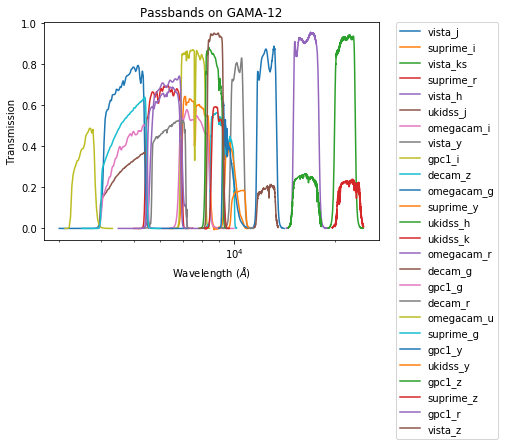

In [16]:
for b in bands:
    plt.plot(Table(data = parse_single_table(FILTERS_DIR + b + '.xml').array.data)['Wavelength']
            ,Table(data = parse_single_table(FILTERS_DIR + b + '.xml').array.data)['Transmission']
            , label=b)
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Transmission')
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Passbands on {}'.format(FIELD))

### IV.a - Depth overview
Then we plot the mean depths available across the area a given band is available

In [17]:
average_depths = []
for b in ap_bands:
    
    mean_err = np.nanmean(depths['ferr_ap_{}_mean'.format(b)])
    print("{}: mean flux error: {}, 3sigma in AB mag (Aperture): {}".format(b, mean_err, flux_to_mag(3.0*mean_err*1.e-6)[0]))
    average_depths += [('ap_' + b, flux_to_mag(1.0*mean_err*1.e-6)[0], 
                        flux_to_mag(3.0*mean_err*1.e-6)[0], 
                        flux_to_mag(5.0*mean_err*1.e-6)[0])]
    
for b in tot_bands:
    
    mean_err = np.nanmean(depths['ferr_{}_mean'.format(b)])
    print("{}: mean flux error: {}, 3sigma in AB mag (Total): {}".format(b, mean_err, flux_to_mag(3.0*mean_err*1.e-6)[0]))
    average_depths += [(b, flux_to_mag(1.0*mean_err*1.e-6)[0], 
                        flux_to_mag(3.0*mean_err*1.e-6)[0], 
                        flux_to_mag(5.0*mean_err*1.e-6)[0])]
    
average_depths = np.array(average_depths,  dtype=[('band', "<U16"), ('1s', float), ('3s', float), ('5s', float)])
    

decam_g: mean flux error: 0.31319212913513184, 3sigma in AB mag (Aperture): 23.96766976514582
decam_r: mean flux error: 0.49817511439323425, 3sigma in AB mag (Aperture): 23.463741790203805
decam_z: mean flux error: 0.566842257976532, 3sigma in AB mag (Aperture): 23.323541314828965
suprime_g: mean flux error: 0.02346797101199627, 3sigma in AB mag (Aperture): 26.781008005457572
suprime_r: mean flux error: 0.03223560005426407, 3sigma in AB mag (Aperture): 26.436357466050474
suprime_i: mean flux error: 0.03589833527803421, 3sigma in AB mag (Aperture): 26.319511089688667
suprime_z: mean flux error: 0.07204469293355942, 3sigma in AB mag (Aperture): 25.563191876542312
suprime_y: mean flux error: 0.17221812903881073, 3sigma in AB mag (Aperture): 24.616999696232845
omegacam_u: mean flux error: 0.25683921575546265, 3sigma in AB mag (Aperture): 24.18304352532092
omegacam_g: mean flux error: 0.0991758331656456, 3sigma in AB mag (Aperture): 25.21618221914246
omegacam_r: mean flux error: 0.105213731

In [18]:
def FWHM(X,Y):
    
    half_max = max(Y) / 2.
    #find when function crosses line half_max (when sign of diff flips)
    #take the 'derivative' of signum(half_max - Y[])
    d = half_max - Y
    #plot(X,d) #if you are interested
    #find the left and right most indexes
    low_end = X[np.where(d < 0)[0][0]]
    high_end = X[np.where(d < 0)[0][-1]]
    return low_end, high_end, (high_end - low_end)


In [19]:
data = []

for b in ap_bands:
    data += [['ap_' + b, Table(data = parse_single_table(FILTERS_DIR + b +'.xml').array.data)]]
    
for b in tot_bands:
    data += [[b, Table(data = parse_single_table(FILTERS_DIR + b +'.xml').array.data)]]

In [20]:
wav_range = []
for dat in data:
    print(dat[0], FWHM(np.array(dat[1]['Wavelength']), np.array(dat[1]['Transmission'])))
    wav_range += [[dat[0], FWHM(np.array(dat[1]['Wavelength']), np.array(dat[1]['Transmission']))]]


ap_decam_g (4180.0, 5470.0, 1290.0)
ap_decam_r (5680.0, 7150.0, 1470.0)
ap_decam_z (8490.0, 9960.0, 1470.0)
ap_suprime_g (4090.0, 5460.0, 1370.0)
ap_suprime_r (5440.0, 6960.0, 1520.0)
ap_suprime_i (6980.0, 8420.0, 1440.0)
ap_suprime_z (8540.0, 9280.0, 740.0)
ap_suprime_y (9360.0, 10120.0, 760.0)
ap_omegacam_u (3296.7, 3807.9, 511.19995)
ap_omegacam_g (4077.9, 5369.7, 1291.8003)
ap_omegacam_r (5640.7, 6962.8, 1322.0996)
ap_omegacam_i (6841.5, 8373.8, 1532.2998)
ap_gpc1_g (4260.0, 5500.0, 1240.0)
ap_gpc1_r (5500.0, 6900.0, 1400.0)
ap_gpc1_i (6910.0, 8190.0, 1280.0)
ap_gpc1_z (8190.0, 9210.0, 1020.0)
ap_gpc1_y (9200.0, 9820.0, 620.0)
ap_ukidss_y (9790.0, 10820.0, 1030.0)
ap_ukidss_j (11695.0, 13280.0, 1585.0)
ap_ukidss_h (14925.0, 17840.0, 2915.0)
ap_ukidss_k (20290.0, 23820.0, 3530.0)
ap_vista_z (8300.0, 9260.0, 960.0)
ap_vista_y (9740.0, 10660.0, 920.0)
ap_vista_j (11670.0, 13380.0, 1710.0)
ap_vista_h (15000.0, 17900.0, 2900.0)
ap_vista_ks (19930.0, 23010.0, 3080.0)
decam_g (4180.0, 547

Text(0.5, 1.0, 'Depths on GAMA-12')

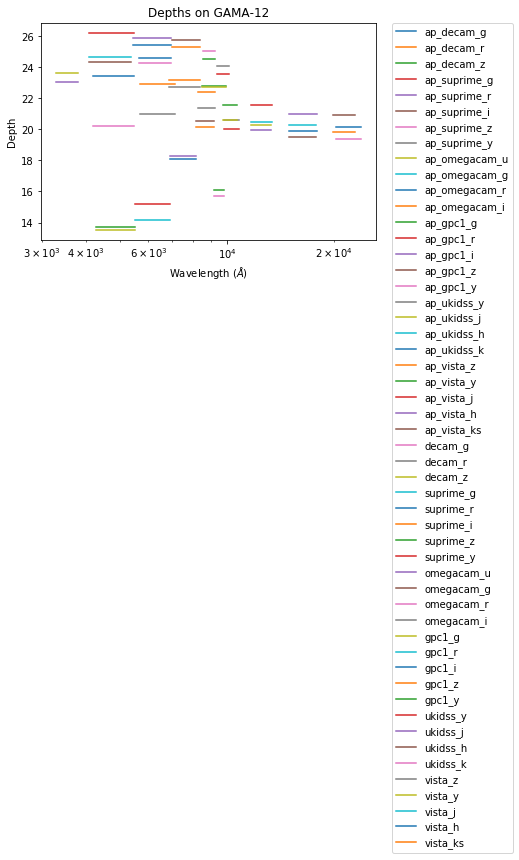

In [21]:
for dat in data:
    wav_deets = FWHM(np.array(dat[1]['Wavelength']), np.array(dat[1]['Transmission']))
    depth = average_depths['5s'][average_depths['band'] == dat[0]]
    #print(depth)
    plt.plot([wav_deets[0],wav_deets[1]], [depth,depth], label=dat[0])
    
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Depth')
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Depths on {}'.format(FIELD))

### IV.c - Depth vs coverage comparison

How best to do this? Colour/intensity plot over area? Percentage coverage vs mean depth?

Text(0.5, 1.0, 'Depths (5 $\\sigma$) vs coverage on GAMA-12')

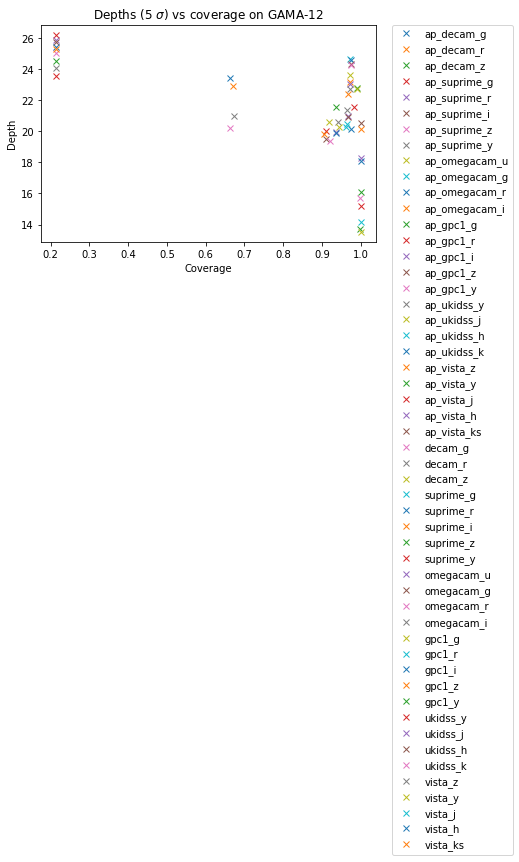

In [22]:
for dat in data:
    wav_deets = FWHM(np.array(dat[1]['Wavelength']), np.array(dat[1]['Transmission']))
    depth = average_depths['5s'][average_depths['band'] == dat[0]]
    #print(depth)
    coverage = np.sum(~np.isnan(depths['ferr_{}_mean'.format(dat[0])]))/len(depths)
    plt.plot(coverage, depth, 'x', label=dat[0])
    
plt.xlabel('Coverage')
plt.ylabel('Depth')
#plt.xscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Depths (5 $\sigma$) vs coverage on {}'.format(FIELD))